In [1]:
# Importamos los módulos necesarios
import torch
import numpy as np
import matplotlib.pyplot as plt
import  os, sys
# necesitamos setear el path como variable de entorno para importar modulos
sys.path.append(os.path.join('..','..','libs'))
from read_smn import read_smn

# Incluyendo otras variables ambientales en la prediccion de la temperatura

Para una estación dada, se pueden pensar varios tipos de problemas: 

1. Conociendo los valores de temperatura (T), humedad (H), presión (P) y magnitud de la velocidad del viento (V) hasta la hora previa, predecir los valores de la siguiente hora.
2. Suponiendo que se rompe el sensor de temperatura, conociendo los valores históricos del conjunto (T, H, P, V) y además los valores actuales de (H,P,V) predecir la temperatura actual.
3. Ejercicio: Conociendo las variables de diferentes estaciones, predecir T, H, P y V para la hora siguiente (sugerencia: predecir para SALTA, utilizando TUCUMAN, JUJUY AERO)

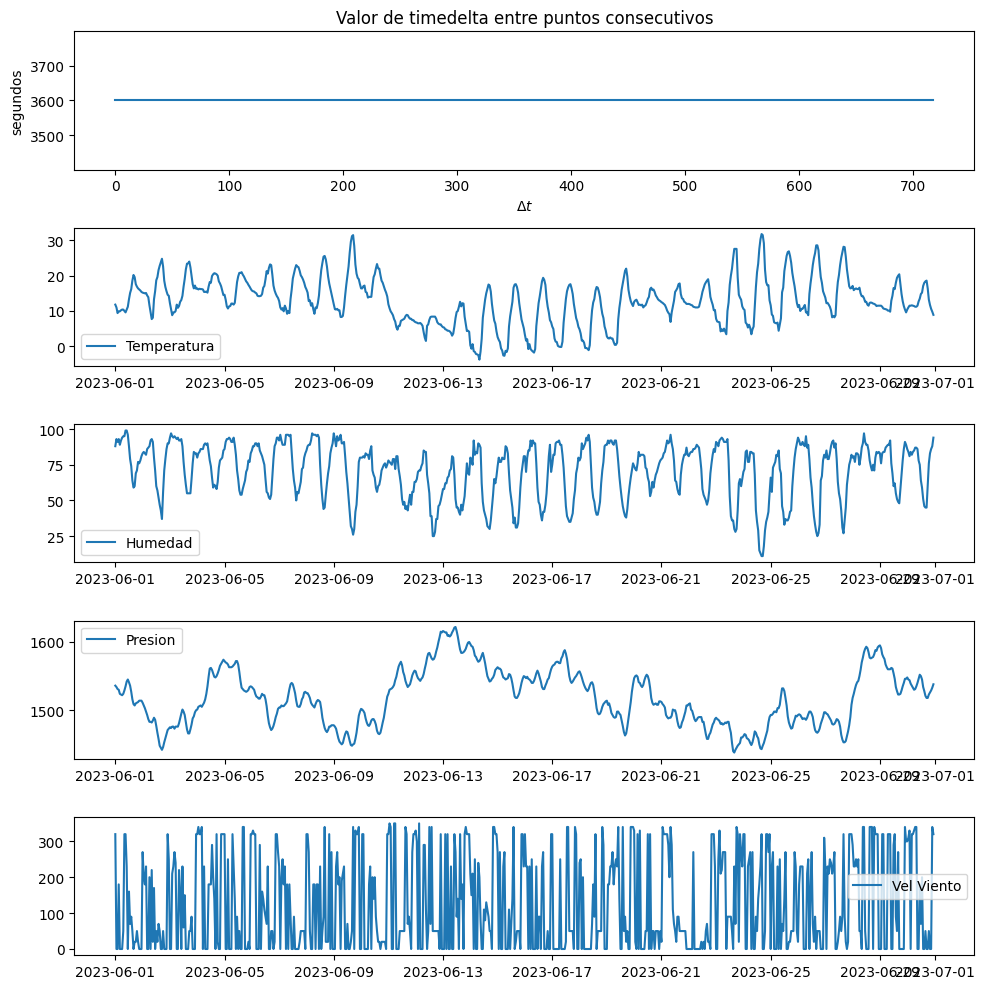

In [2]:
lector = read_smn(os.path.join('..','..','Data','junio-SMN','horario'))
tstamps, data = lector.filter_by_station('SALTA')

# verificamos que los datos estén completos
dt = tstamps[1:]-tstamps[:-1]
labels = ['Temperatura', 'Humedad', 'Presion', 'Vel Viento']
fig, axs = plt.subplots(5,1, figsize = (10,10))
axs[0].set_title('Valor de timedelta entre puntos consecutivos')
axs[0].set_xlabel('$\Delta t$')
axs[0].set_ylabel('segundos')
axs[0].plot([d.total_seconds() for d in dt])
for i in range(1,5):
    axs[i].plot(tstamps, data[:,i-1], label = labels[i-1])
    axs[i].legend()
fig.tight_layout()

## Acondicionando los datos

Como las diferentes series no tienen valores similares, es preciso normalizarlas de alguna manera para que la red neuronal las pese por igual a todas. Para ello vamos a utilizar las herramientas que proporciona Sci-Kit Learn.

In [3]:
# Vamos a separar todo el dataset en una parte de entrenamiento y otra de validacion
from sklearn.model_selection import train_test_split
train, valid = train_test_split(data[:,:-1],test_size=0.2, shuffle=False) # Vamos a obviar la direccion del viento
tstamps_tr, tstamps_val = train_test_split(tstamps,test_size=0.2,shuffle=False) # Ojo con el Shuffle aqui
print(train.shape, valid.shape, tstamps_tr.shape)

(576, 4) (144, 4) (576,)


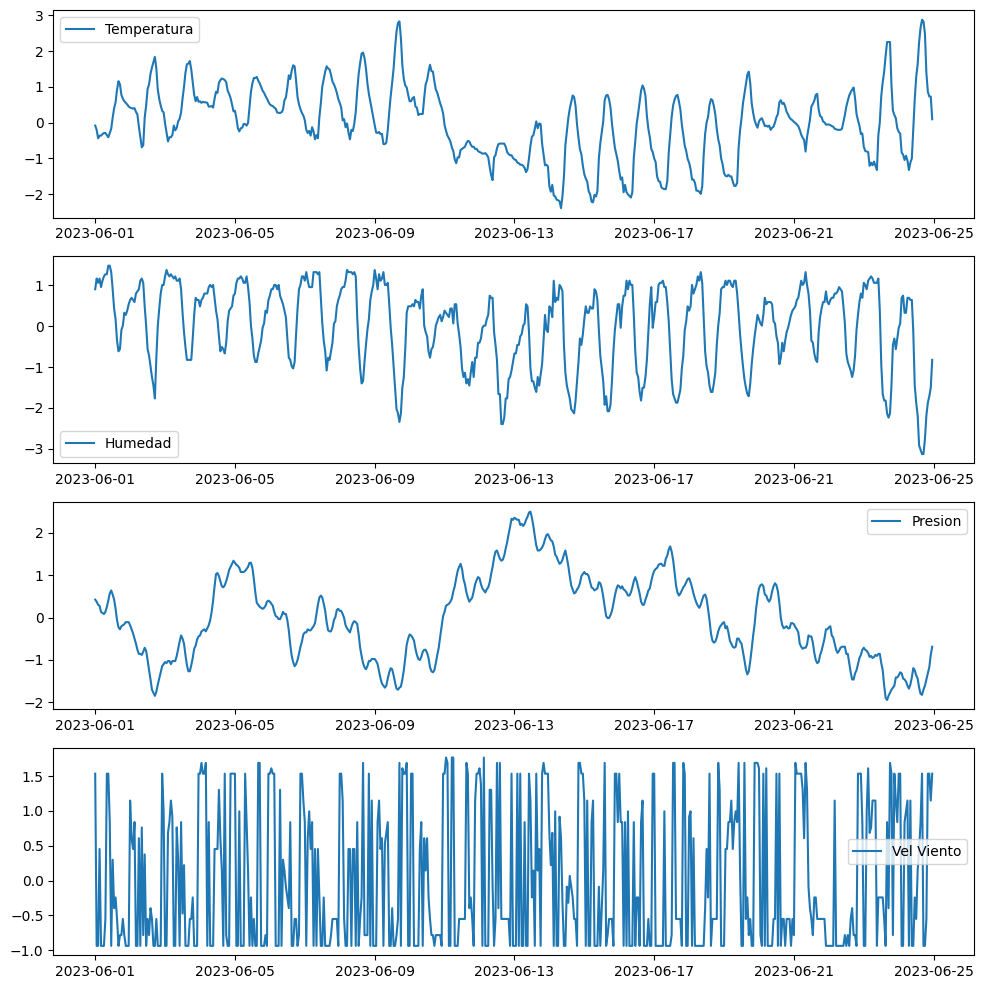

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train = scaler.fit_transform(train)  # TRansformamos solo el conjunto de entrenamiento
fig, axs = plt.subplots(4,1, figsize = (10,10))
for i in range(0,4):
    axs[i].plot(tstamps_tr, train[:,i], label = labels[i])
    axs[i].legend()
fig.tight_layout()

In [11]:
# ahora transformamos el conjunto de validacion
valid = scaler.transform(valid)

## Dataset y Dataloader

Vamos a crear un dataset para el **ejercicio 1**. Tomaremos una serie de datos previos (lookback), para predecir los datos futuros

In [12]:
class Dataset_delayed(torch.utils.data.Dataset):
    # constructor
    def __init__(self, data, lookback = 1):
        self.data = data
        self.lookback = lookback
        # partimos los datos en series con lookback
        self._split_X_Y()
        # convertimos los vectores de NumPy en tensores de PyTorch
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float()

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def _split_X_Y(self):
        self.X = []
        self.Y = []
        for i in range(self.data.shape[0]-self.lookback):
            self.X.append(self.data[i:i+self.lookback, :].flatten()) # Flatten reduce todo el vector a 1D
            self.Y.append(self.data[i+self.lookback,:])
        self.X = np.array(self.X)
        self.Y = np.array(self.Y)

In [13]:
# creamos los datasets y dataloaders en un diccionario para manejar mas simple
lookback = 12
dataset = {'train': Dataset_delayed(train, lookback= lookback),
            'valid' : Dataset_delayed(valid, lookback= lookback)}

dataloader = {'train' : torch.utils.data.DataLoader(dataset['train'], batch_size = 32, shuffle= True),
            'valid' : torch.utils.data.DataLoader(dataset['valid'], batch_size = 32, shuffle= True)}

## Creación de la NN

Ahora es importante notar que el numero de entradas va a ser igual a la cantidad de variables, es decir:

n_features_in = n_maginudes * lookback 

In [14]:
class Multivariado_MLP(torch.nn.Module):
    def __init__(self, n_in , n_hidden, n_out) -> None:
        super(Multivariado_MLP,self).__init__()

        self.n_in       = n_in
        self.n_hidden   = n_hidden
        self.n_out      = n_out
        self.linear_1   = torch.nn.Linear(n_in, n_hidden)
        self.act_1      = torch.nn.Tanh()
        self.linear_2   = torch.nn.Linear(n_hidden, n_hidden)
        self.act_2      = torch.nn.Tanh()
        self.linear_3   = torch.nn.Linear(n_hidden, n_out)
    
    def forward(self, x):
        x = self.act_1(self.linear_1(x))
        x = self.act_2(self.linear_2(x))
        x = self.linear_3(x)
        return x

In [18]:
n_magn = 4
mlp = Multivariado_MLP(n_magn*lookback, 64, n_magn)

def fit(model, dataloader, epochs = 10):
    '''
    Funcion para entrenar el modelo model utilizando un dataloader
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
    criterion = torch.nn.MSELoss()
    history = []
    for epoch in range(1,epochs+1):
        model.train()   # ponemos el modelo para ser entrenado
        train_h = [] 
        
        # leer los datos en el dataloader es muy simple (recorrer por batches)! 
        for x_b, y_b in dataloader['train']:

            # ponemos los gradientes a cero
            optimizer.zero_grad()
            
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            # calculamos los gradientes
            loss.backward()
            
            # actualizamos todos los pesos
            optimizer.step()
            train_h.append(loss.item())

        model.eval() # no estamos entrenando
        test_h = [] 
        with torch.no_grad():  # no vamos a hacer backward, solo ver la metrica sobre el test
            for x_b, y_b in dataloader['valid']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                test_h.append(loss.item())
        if (epoch%2 == 0):
            print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h):.3f} - valid loss: {np.mean(test_h):.3f}')                
        history.append([np.mean(train_h), np.mean(test_h)])
    return history


In [19]:
hist = fit(mlp, dataloader, epochs=10)
print('----------------------------------------------')
print(f'train loss: {hist[-1][0]} - valid loss: {hist[-1][1]}')
print('----------------------------------------------')

epoch: 2/10 - train loss: 0.407 - valid loss: 0.415
epoch: 4/10 - train loss: 0.314 - valid loss: 0.383
epoch: 6/10 - train loss: 0.278 - valid loss: 0.308
epoch: 8/10 - train loss: 0.257 - valid loss: 0.288
epoch: 10/10 - train loss: 0.250 - valid loss: 0.266
----------------------------------------------
train loss: 0.24965567058987087 - valid loss: 0.26568579077720644
----------------------------------------------


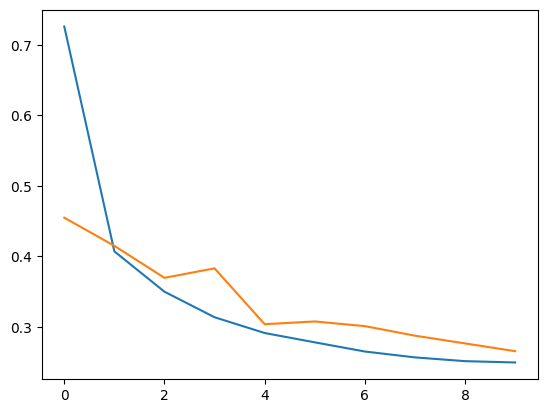

In [20]:
plt.plot([h[0] for h in hist])
plt.plot([h[1] for h in hist])

## Viendo las predicciones

torch.Size([1, 4])


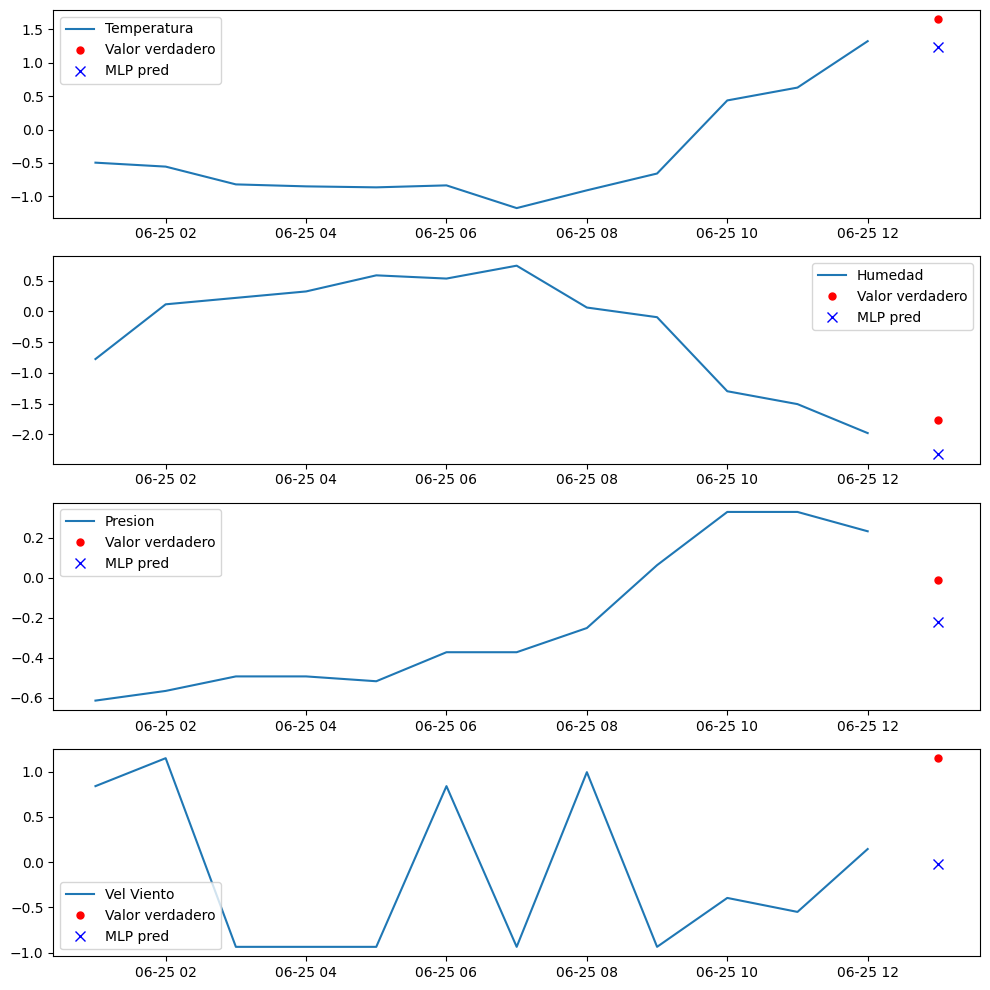

In [47]:
idx = 1
single_sample = valid[idx:idx+lookback,:]
preds = mlp(torch.from_numpy(single_sample).float().view(1,-1))
print(preds.shape)
fig, axs = plt.subplots(4,1, figsize = (10,10))
for i in range(0,4):
    axs[i].plot(tstamps_val[idx : idx + lookback], valid[idx:idx+lookback,i], label = labels[i])
    axs[i].plot(tstamps_val[idx + lookback], valid[idx + lookback,i], 'ro', ms =5, label = 'Valor verdadero')
    axs[i].plot(tstamps_val[idx + lookback], preds[0,i].detach().numpy(), 'bx', ms = 7, label = 'MLP pred')
    axs[i].legend()
fig.tight_layout()

Los valores previos son valores escalados, por lo que resulta conveniente realizar el scaling inverso

(1, 4)


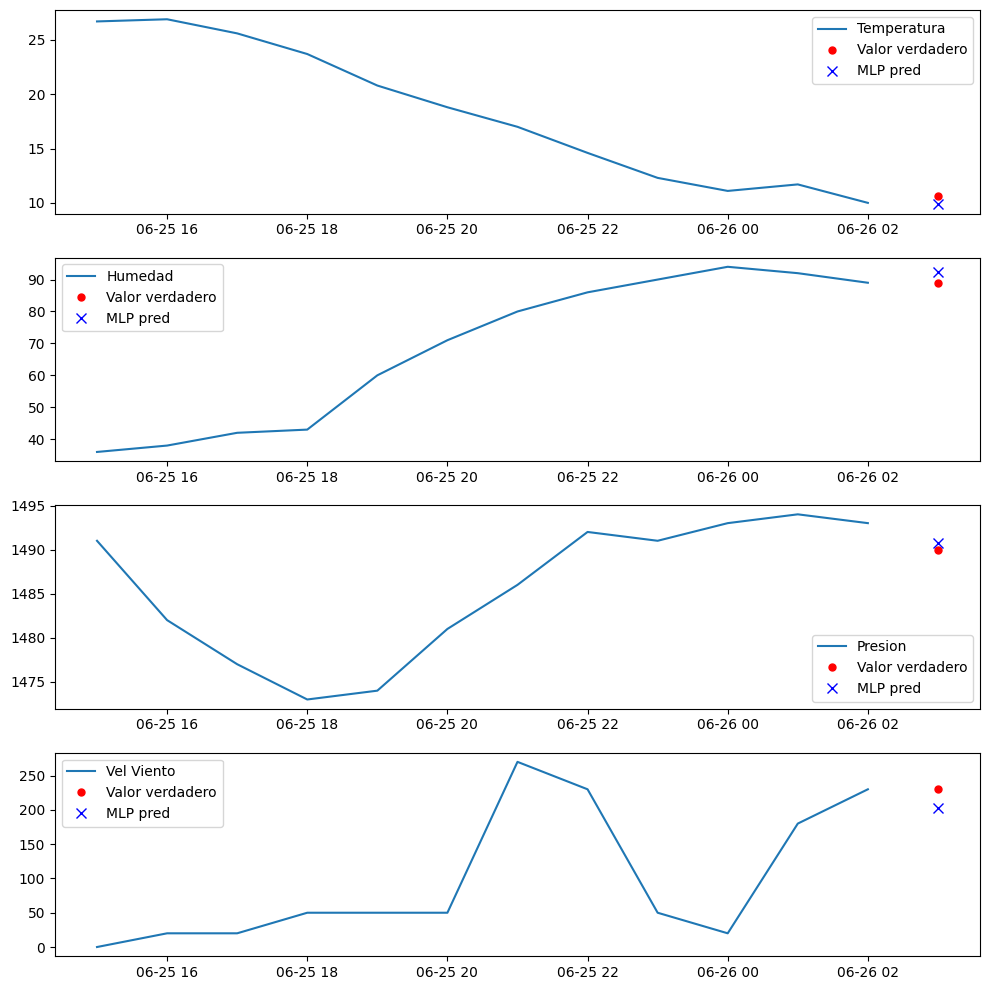

In [57]:
idx = 15
single_sample = valid[idx:idx+lookback+1,:]
preds = mlp(torch.from_numpy(single_sample[:-1,:]).float().view(1,-1))
single_sample = scaler.inverse_transform(single_sample)
preds = scaler.inverse_transform(preds.detach().numpy())
print(preds.shape)
fig, axs = plt.subplots(4,1, figsize = (10,10))
for i in range(0,4):
    axs[i].plot(tstamps_val[idx : idx + lookback],single_sample[:-1,i], label = labels[i])
    axs[i].plot(tstamps_val[idx + lookback], single_sample[-1,i], 'ro', ms =5, label = 'Valor verdadero')
    axs[i].plot(tstamps_val[idx + lookback], preds[0,i], 'bx', ms = 7, label = 'MLP pred')
    axs[i].legend()
fig.tight_layout()

**Se deja como ejercicio variar el modelo (numero de capas ocultas, neuronas, etc), el lookback y calcular el error absoluto que comete este modelo sobre el conjunto de validacion. Compararlo con el modelo naive**

De todo lo anterior se puede ver que el procesamiento se vuelve engorroso para ser trabajado de manera manual y caso por caso, por ello definiremos *pipelines* de transformaciones de los datos que permitan empaquetar todas las transformaciones que sean necesarias mediante clases y funciones

Esto se realizara para el ejercicio 2

## Ejercicio 2
Suponiendo que se rompe el sensor de temperatura, conociendo los valores históricos del conjunto (T, H, P, V) y además los valores actuales de (H,P,V) predecir la temperatura actual.

### Vamos a comenzar por el principio

Ahora que se conocen los datos, vamos a comenzar por construir una clase que realice todo el preprocesamiento

In [119]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

class Preprocessor:
    def __init__(self, tstamps, raw_data, lookback):
        self.tstamps = tstamps
        self.raw_data = raw_data
        self.lookback = lookback
        self.split_train_test_valid()
        self.create_fit_scaler()

    def split_train_test_valid(self):
        # split en train, test y valid
        self.train_t, self.test_t = train_test_split(self.tstamps, test_size=0.3, shuffle= False) # 70% de entrenamiento
        self.train_raw, self.test_raw = train_test_split(self.raw_data, test_size=0.3, shuffle= False)

    def create_fit_scaler(self):
        # Scaling de los datos
        self.scaler = StandardScaler()
        self.train_scaled = self.scaler.fit_transform(self.train_raw)
        self.test_scaled  = self.scaler.transform(self.test_raw)

    def scale_single_sample(self, x):
        return self.scaler.transform(x)
    
    def inverse_scale_single_sample(self,x):
        return self.scaler.inverse_transform(x)

    def create_features_ground_truth(self, x):
        assert len(x) > lookback, 'La serie es muy corta'
        X = []
        Y = []
        for i in range(len(x)-self.lookback):
            X.append( np.hstack( [ x[i:i+self.lookback,:].flatten(), 
                                  x[i+self.lookback,1:] ] ) )   # ponemos todas las features una al lado de la otra
            Y.append( x[i+self.lookback,0] )                    # Queremos predecir solo la primera
        return np.array(X), np.array(Y)

    def create_features(self, x):
        assert len(x) > lookback, 'La serie es muy corta'
        X = []
        for i in range(len(x)-self.lookback):
            X.append( np.hstack( [ x[i:i+self.lookback,:].flatten(), 
                                  x[i+self.lookback,1:] ] ) )   # ponemos todas las features una al lado de la otra
        return np.array(X)


In [160]:
preproc = Preprocessor(tstamps, data[:,:-1], lookback=12)
print(f'Numero de features totales: {preproc.create_features_ground_truth(preproc.train_scaled)[0].shape}')

Numero de features totales: (492, 51)


In [161]:
class Dataset_delayed(torch.utils.data.Dataset):
    # constructor
    def __init__(self, preprocessor, istest = False):
        self.preproc = preprocessor
        # partimos los datos en series con lookback
        if istest:
            self.X, self.Y = self.preproc.create_features_ground_truth(self.preproc.test_scaled)
        else:
            self.X, self.Y = self.preproc.create_features_ground_truth(self.preproc.train_scaled)
        # convertimos los vectores de NumPy en tensores de PyTorch
        self.X = torch.from_numpy(self.X).float()
        self.Y = torch.from_numpy(self.Y).float().view(-1,1)

    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

dataset = {'train': Dataset_delayed(preproc, istest = False),
            'test': Dataset_delayed(preproc, istest = True)}

dataloader = {'train' : torch.utils.data.DataLoader(dataset['train'], batch_size = 32, shuffle= True),
            'test' : torch.utils.data.DataLoader(dataset['test'], batch_size = 32, shuffle= True)}

In [185]:
class Multivariado_MLP(torch.nn.Module):
    def __init__(self, n_in , n_hidden, n_out) -> None:
        super(Multivariado_MLP,self).__init__()

        self.n_in       = n_in
        self.n_hidden   = n_hidden
        self.n_out      = n_out
        self.linear_1   = torch.nn.Linear(n_in, n_hidden)
        self.act_1      = torch.nn.ReLU()
        self.linear_2   = torch.nn.Linear(n_hidden, n_hidden)
        self.act_2      = torch.nn.ReLU()
        self.linear_3   = torch.nn.Linear(n_hidden, n_out)
        self.dropout    = torch.nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.act_1(self.linear_1(x))
        x = self.dropout(x)
        x = self.act_2(self.linear_2(x))
        self.dropout(x)
        x = self.linear_3(x)
        return x

In [189]:
n_magn = 4  # el numero total de features
missing = 1 # la temperatura que falta
mlp = Multivariado_MLP(n_magn*preproc.lookback + n_magn - missing, 64, missing)

def fit(model, dataloader, epochs = 10):
    '''
    Funcion para entrenar el modelo model utilizando un dataloader
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr= 0.0001)
    criterion = torch.nn.MSELoss()
    history = []
    for epoch in range(1,epochs+1):
        model.train()   # ponemos el modelo para ser entrenado
        train_h = [] 
        
        # leer los datos en el dataloader es muy simple (recorrer por batches)! 
        for x_b, y_b in dataloader['train']:

            # ponemos los gradientes a cero
            optimizer.zero_grad()
            
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)

            # calculamos los gradientes
            loss.backward()
            
            # actualizamos todos los pesos
            optimizer.step()
            train_h.append(loss.item())

        model.eval() # no estamos entrenando
        test_h = [] 
        with torch.no_grad():  # no vamos a hacer backward, solo ver la metrica sobre el test
            for x_b, y_b in dataloader['test']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                test_h.append(loss.item())
        if (epoch%2 == 0):
            print(f'epoch: {epoch}/{epochs} - train loss: {np.mean(train_h):.3f} - test loss: {np.mean(test_h):.3f}')                
        history.append([np.mean(train_h), np.mean(test_h)])
    return history

In [190]:
hist = fit(mlp, dataloader, epochs=100)
print('----------------------------------------------')
print(f'train loss: {hist[-1][0]} - valid loss: {hist[-1][1]}')
print('----------------------------------------------')

epoch: 2/100 - train loss: 1.015 - test loss: 1.009
epoch: 4/100 - train loss: 0.967 - test loss: 0.915
epoch: 6/100 - train loss: 0.839 - test loss: 0.858
epoch: 8/100 - train loss: 0.751 - test loss: 0.685
epoch: 10/100 - train loss: 0.631 - test loss: 0.615
epoch: 12/100 - train loss: 0.537 - test loss: 0.529
epoch: 14/100 - train loss: 0.436 - test loss: 0.476
epoch: 16/100 - train loss: 0.353 - test loss: 0.371
epoch: 18/100 - train loss: 0.327 - test loss: 0.315
epoch: 20/100 - train loss: 0.305 - test loss: 0.296
epoch: 22/100 - train loss: 0.292 - test loss: 0.275
epoch: 24/100 - train loss: 0.243 - test loss: 0.258
epoch: 26/100 - train loss: 0.217 - test loss: 0.232
epoch: 28/100 - train loss: 0.215 - test loss: 0.211
epoch: 30/100 - train loss: 0.216 - test loss: 0.202
epoch: 32/100 - train loss: 0.200 - test loss: 0.204
epoch: 34/100 - train loss: 0.206 - test loss: 0.206
epoch: 36/100 - train loss: 0.197 - test loss: 0.178
epoch: 38/100 - train loss: 0.188 - test loss: 0.1

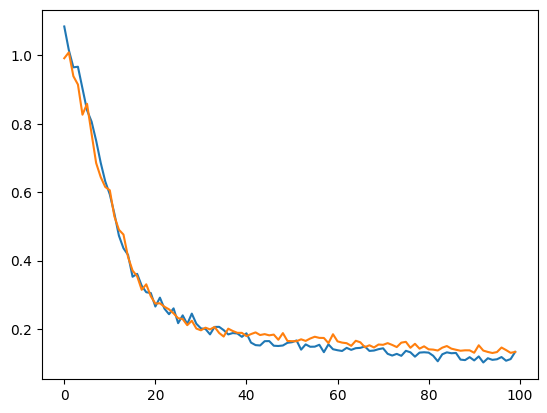

In [191]:
plt.plot(hist)